Época 1, Erro: 0.7571210608022654
Época 2, Erro: 0.5395744629000037
Época 3, Erro: 0.49792073488030475
Época 4, Erro: 0.4245502111178371
Época 5, Erro: 0.30677334095565056
Época 6, Erro: 0.22755955744279624
Época 7, Erro: 0.16529749069504757
Época 8, Erro: 0.093965998429337
Época 9, Erro: 0.2425716866200681
Época 10, Erro: 0.06265088441331915
Época 11, Erro: 0.12773319944825332
Época 12, Erro: 0.11900750633423664
Época 13, Erro: 0.092029672568776
Época 14, Erro: 0.11421094267598064
Época 15, Erro: 0.10810133146034437
Época 16, Erro: 0.10519993889609398
Época 17, Erro: 0.11690506108031111
Época 18, Erro: 0.10895543315948418
Época 19, Erro: 0.11459526704017507
Época 20, Erro: 0.11139086374900069
Época 21, Erro: 0.11494270286754124
Época 22, Erro: 0.11169267895696589
Época 23, Erro: 0.11613176933873495
Época 24, Erro: 0.11224845914461626
Época 25, Erro: 0.11773284779446927
Época 26, Erro: 0.11275243060847459
Época 27, Erro: 0.11998825855566415
Época 28, Erro: 0.11283893549482621
Época 29,

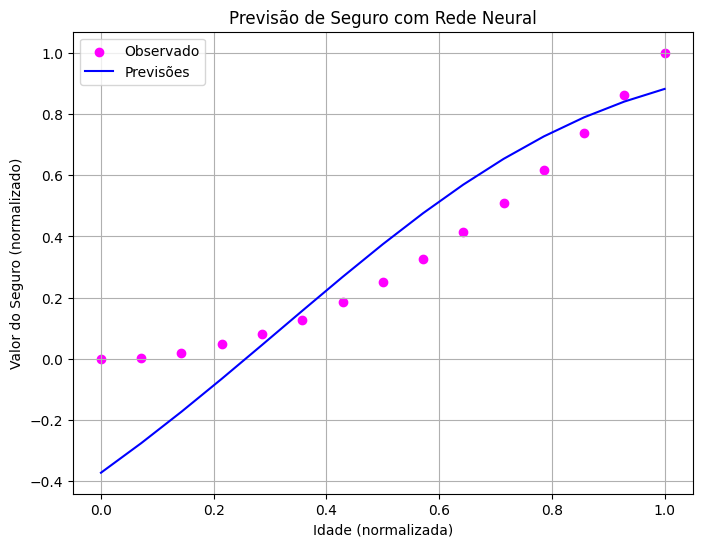

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt


# calculo diferencial entre dois pontos 
    

def diferencial(f,x, h=1e-5):
        return (f(x + h) - f(x)) / h


class Neuronio:

    def __init__(self,d,phi):       
        #super.__init__()
        self.d = d
        self.phi = phi 

        self.w = np.random.uniform(-1, 1, d)

        self.b = np.random.uniform(-1, 1)
        
        self.delta_w = np.zeros(d)

        self.delta_b = 0

        self.h = 0 
        self.y = 0
        self.y1 = 0
    
    
    def propagar(self,x):
        self.h = np.dot(self.w, x) + self.b # np.dot representa o escalar 
        self.y = self.phi(self.h)
        self.y1 = diferencial(self.phi,self.h)
        return self.y 
       
    

    def adaptar(self, delta, y_anterior, alpha, beta): 
        y_anterior = np.array(y_anterior)
        Mw = beta * self.delta_w
        self.deltaw = -alpha * self.y1 * delta * y_anterior + beta + Mw
        self.w += self.delta_w

        Mb = beta * self.delta_b
        self.delta_b = -alpha * self.y1 * delta + Mb
        self.b += self.delta_b

        


class CamadaDensa:
    def __init__(self, de, ds, phi):
        self.de = de 
        self.ds = ds
        self.phi = phi 

        self.neuronios = [Neuronio(de, phi) for _ in range(ds)]

    def propagar(self, x):
        self.y = [neuronio.propagar(x) for neuronio in self.neuronios]
        return self.y 
    
    def saida(self):
        return [neuronio.y for neuronio in self.neuronios]
     
    def adaptar(self, delta_n, y_anterior, alpha, beta):
        for j in range(self.ds):
            self.neuronios[j].adaptar(delta_n[j], y_anterior, alpha, beta)
    
class CamadaEntrada:
    def __init__(self, ds):
        self.ds = ds  
        self.y = [0 for _ in range(ds)]

    def propagar(self, x):
        self.y = x  
        return self.y

class RedeNeuronal:
    def __init__(self, forma, phi):
        self.camadas = []   
        self.N = len(forma)  
        ds1 = forma[0]
        camada_entrada = CamadaEntrada(ds1)
        self.camadas.append(camada_entrada)

        for n in range(1, self.N):
            de_n = forma[n - 1]  
            ds_n = forma[n]  
            camada_densa = CamadaDensa(de_n, ds_n, phi)
            self.camadas.append(camada_densa)

    def delta_saida(self, yN, y):
        return [yN[k] - y[k] for k in range(len(y))]
    
    def retropropagar(self, deltaN, alpha, beta):
        delta_atual = deltaN
        
        for n in range(len(self.camadas) -1, 0, -1): 
            camada_atual = self.camadas[n]
            camada_anterior = self.camadas[n - 1]


            y_anterior = camada_anterior.y
            #derivada_anterior = [neuronio.y1 for neuronio in camada_anterior.neuronios]
            if isinstance(camada_anterior, CamadaDensa):
                derivada_anterior = [neuronio.y1 for neuronio in camada_anterior.neuronios]
            else:
                derivada_anterior = [1] * len(camada_anterior.y)  # Derivada trivial para a entrada

            delta_anterior = []
            for i in range(len(camada_anterior.y)):
                soma = sum(
                    camada_atual.neuronios[J].w[i] * delta_atual[J]
                    for J in range(len(camada_atual.neuronios))
                )
                delta_anterior.append(soma * derivada_anterior[i])

            camada_atual.adaptar(delta_atual, y_anterior, alpha, beta)
            delta_atual = delta_anterior
    
    def adaptar(self, x, y, alpha, beta):
        yN = self.propagar(x)
        delta_n = self.delta_saida(yN, y)

        self.retropropagar(delta_n, alpha, beta)

        k = len(delta_n)
        erro_medio = (1/k) * sum(delta ** 2 for delta in delta_n)

        return erro_medio

    def treinar(self, x, y, n_epocas, epsilon_max, alpha, beta):
        historico_erro = []

        for epoca in range(n_epocas):
            erro_epoca = 0

            for entrada,saida in zip(x,y):
                erro_x = self.adaptar(entrada,saida, alpha, beta)
                erro_epoca = max(erro_epoca, erro_x)

            historico_erro.append(erro_epoca)
            print(f"Época {epoca + 1}, Erro: {erro_epoca}")

            if erro_epoca <= epsilon_max:
                print("Treinamento concluído. Erro aceitável atingido.")
            

        return historico_erro
    
    def prever(self,X):
        Y = [self.propagar(x) for x in X]
        return Y

    def propagar(self, x):
        y = x
        for camada in self.camadas:
            y = camada.propagar(y)
        return y
    
    
    
   
    
# ambiente de testes para o problema XOR 

def sigmoid(x):
    return (1 / (1+np.exp(-x))) # np.exp significa o exponencial do valor

def sigmoid_derivada(x):
    s = sigmoid(x)
    return s * (1-s)

def tah(x):
    return np.tanh(x)

def tah_derivada(x):
    return 1 - np.tanh(x) **2


#forma = [2, 3, 1]
#forma = [2, 3, 1]
#forma = [1, 10, 1]

#rede = RedeNeuronal(forma, sigmoid)
#rede.camadas[-1].neuronios = [Neuronio(3, sigmoid)]
"""
X = np.array([
    [-1, -1],
    [-1, 1],
    [1, -1],
    [1, 1]
]) 

X = np.array([
    [0, 0],
    [0, 1],
    [1, 0],
    [1, 1]
])

Y = np.array([
    [0],
    [1],
    [1],
    [0]
])"""

""" #n_epocas = 5000        # Número de épocas
n_epocas = 700
epsilon_max = 0.03      # Erro máximo permitido
alpha = 0.1               # Taxa de aprendizado

#n_epocas = 5000        # Número de épocas
n_epocas = 10000
epsilon_max = 0.01     # Erro máximo permitido  
alpha = 0.5            # Taxa de aprendizado # rate learning 
beta = 0.7         # Factor de momento

historico_erro = rede.treinar(X, Y, n_epocas, epsilon_max, alpha, beta)

# Exibir o histórico do erro
plt.plot(historico_erro)
plt.title('Evolução do Erro')
plt.xlabel('Épocas')
plt.ylabel('Erro')
plt.show()


predicoes = rede.prever(X)

for i, (entrada, saida) in enumerate(zip(X, predicoes)):
    print(f"Entrada: {entrada}, Saída esperada: {Y[i]}, Previsão: {saida}")
beta = 0.5         # Fator de momento """ 

np.random.seed(42)
idades = np.linspace(18, 60, 15)  # Idades entre 18 e 60 anos
valores_seguro = 0.01 * (idades - 18)**2 + 0.2 + np.random.normal(0, 0.02, len(idades))  # Relação quadrática com ruído

idades_norm = (idades - min(idades)) / (max(idades) - min(idades))  # Normaliza para [0, 1]
valores_seguro_norm = (valores_seguro - min(valores_seguro)) / (max(valores_seguro) - min(valores_seguro))

X = idades_norm.reshape(-1, 1)  # Idades (entrada)
Y = valores_seguro_norm.reshape(-1, 1)  # Valores do seguro (saída)

forma = [1, 20, 1]  # 1 neurônio na entrada, 10 na camada oculta, 1 na saída
rede = RedeNeuronal(forma, tah)  # Rede criada com sigmoid para regressão

n_epocas = 5000        # Número de épocas
epsilon_max = 0.01     # Erro máximo permitido
alpha = 0.5            # Taxa de aprendizado
beta = 0.9           # Fator de momento

# Treinar a rede
historico_erro = rede.treinar(X, Y, n_epocas, epsilon_max, alpha, beta)

predicoes = rede.prever(X)

mae = np.mean(np.abs(Y - predicoes))
percent_acerto = 100 * (1 - mae)

# Exibir a porcentagem de acerto
print(f"Porcentagem de Acerto: {percent_acerto:.2f}%")

plt.figure(figsize=(8, 6))
plt.scatter(X, Y, color='magenta', label='Observado')  # Dados reais
plt.plot(X, predicoes, color='blue', label='Previsões')  # Previsões da rede
plt.title('Previsão de Seguro com Rede Neural')
plt.xlabel('Idade (normalizada)')
plt.ylabel('Valor do Seguro (normalizado)')
plt.legend()
plt.grid(True)
plt.show()



In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

d = 8
d = d

deltaw = [0 for _ in range(d)]  #np.exp(-x)

print(deltaw)


[0, 0, 0, 0, 0, 0, 0, 0]


In [8]:
X = 2.0


def diferencial(f,x, h=1e-5):
    return (f(x * h) - f(x)) / h

def func(x):
    #calc =  x**2 + 3*x *2
    #print(calc)
    return x**2 + 3*x *2

result = diferencial(func,X)

print(result)

-1599987.9999599997


In [9]:
delta_w = np.zeros(d) 

print(delta_w)

[0. 0. 0. 0. 0. 0. 0. 0.]


In [10]:
def delta_saida(y_n, y):
        return [y_n[k] - y[k] for k in range(len(y))]


y_n = [0.5, 0.2, 0.1]
y = [0.1, 0.8, 0.4]


delta = delta_saida(y_n, y)

print(delta)

[0.4, -0.6000000000000001, -0.30000000000000004]


In [65]:
import pandas as pd

# 1. Gerar um dataset simples para o problema de seguro
np.random.seed(42)
idades = np.linspace(18, 60, 15)  # Idades entre 18 e 60 anos
valores_seguro = 0.01 * (idades - 18)**2 + 0.2 + np.random.normal(0, 0.02, len(idades))  # Relação quadrática com ruído



# Normalizar os dados (boa prática para redes neurais)
idades_norm = (idades - min(idades)) / (max(idades) - min(idades))  # Normaliza para [0, 1]
valores_seguro_norm = (valores_seguro - min(valores_seguro)) / (max(valores_seguro) - min(valores_seguro))

dataset = {"idades": idades, "valores_seguro": valores_seguro}
df = pd.DataFrame(dataset)

print(df)


idades_norm
valores_seguro_norm

    idades  valores_seguro
0     18.0        0.209934
1     21.0        0.287235
2     24.0        0.572954
3     27.0        1.040461
4     30.0        1.635317
5     33.0        2.445317
6     36.0        3.471584
7     39.0        4.625349
8     42.0        5.950611
9     45.0        7.500851
10    48.0        9.190732
11    51.0       11.080685
12    54.0       13.164839
13    57.0       15.371734
14    60.0       17.805502


array([0.        , 0.00439318, 0.0206313 , 0.04720088, 0.08100805,
       0.12704239, 0.18536771, 0.25093902, 0.32625696, 0.414361  ,
       0.51040112, 0.61781191, 0.73625958, 0.86168293, 1.        ])